### 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [3]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [4]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 패딩 추가
# 가장 마지막 위치의 단어가 state에 가장 많은 영향을 미치므로 padding은 pre로 지정.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### validation set 구성

In [5]:
# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### 모델 구성

In [10]:
vocab_size = 10000
word_vector_dim = 200

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [12]:
# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련 LSTM

In [13]:
epochs=5

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 8s 33ms/step - loss: 0.4404 - accuracy: 0.8105 - val_loss: 0.3479 - val_accuracy: 0.8475
Epoch 2/5
247/247 [==============================] - 8s 33ms/step - loss: 0.3225 - accuracy: 0.8631 - val_loss: 0.3349 - val_accuracy: 0.8555
Epoch 3/5
247/247 [==============================] - 8s 34ms/step - loss: 0.2933 - accuracy: 0.8757 - val_loss: 0.3377 - val_accuracy: 0.8562
Epoch 4/5
247/247 [==============================] - 8s 33ms/step - loss: 0.2699 - accuracy: 0.8864 - val_loss: 0.3387 - val_accuracy: 0.8575
Epoch 5/5
247/247 [==============================] - 8s 33ms/step - loss: 0.2467 - accuracy: 0.8966 - val_loss: 0.3487 - val_accuracy: 0.8569


### 모델 훈련 1-D CNN

In [16]:
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 3

history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
247/247 [==============================] - 9s 38ms/step - loss: 0.4332 - accuracy: 0.7926 - val_loss: 0.3384 - val_accuracy: 0.8540
Epoch 2/3
247/247 [==============================] - 9s 37ms/step - loss: 0.2920 - accuracy: 0.8777 - val_loss: 0.3247 - val_accuracy: 0.8604
Epoch 3/3
247/247 [==============================] - 9s 38ms/step - loss: 0.2237 - accuracy: 0.9119 - val_loss: 0.3453 - val_accuracy: 0.8559


### 모델 훈련 GlobalAveragePooling1D layer

In [17]:
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
247/247 [==============================] - 8s 30ms/step - loss: 0.5335 - accuracy: 0.7476 - val_loss: 0.3854 - val_accuracy: 0.8382
Epoch 2/3
247/247 [==============================] - 8s 33ms/step - loss: 0.3611 - accuracy: 0.8476 - val_loss: 0.3603 - val_accuracy: 0.8442
Epoch 3/3
247/247 [==============================] - 8s 33ms/step - loss: 0.3359 - accuracy: 0.8587 - val_loss: 0.3522 - val_accuracy: 0.8490


### 모델 평가

In [18]:
# LSTM
print("LSTM")
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)
print("-------------------------------------------------------------------------")

# 1-D CNN
print("1-D CNN")
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)
print("-------------------------------------------------------------------------")

# GlobalAveragePooling1D
print("GlobalAveragePooling1D layer")
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

LSTM
1537/1537 - 7s - loss: 0.3565 - accuracy: 0.8516
[0.35653436183929443, 0.8515775799751282]
-------------------------------------------------------------------------
1-D CNN
1537/1537 - 8s - loss: 0.3547 - accuracy: 0.8526
[0.35466399788856506, 0.8525744080543518]
-------------------------------------------------------------------------
GlobalMaxPooling1D layer
1537/1537 - 4s - loss: 0.3655 - accuracy: 0.8442
[0.3655129671096802, 0.8441931009292603]


### 그래프 시각화 LSTM

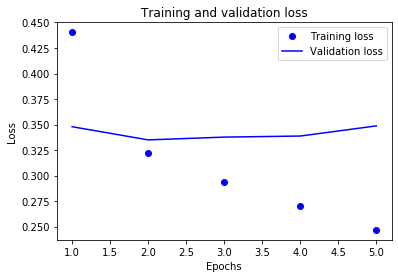

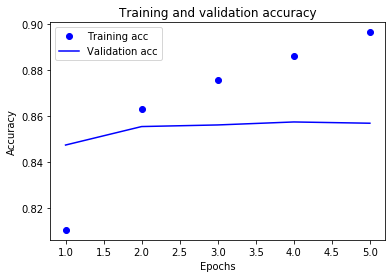

In [19]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 그래프 시각화 1-D CNN

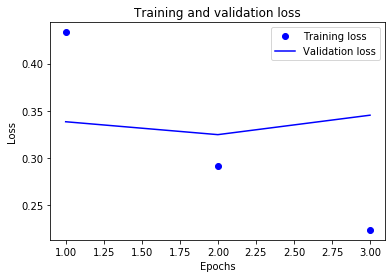

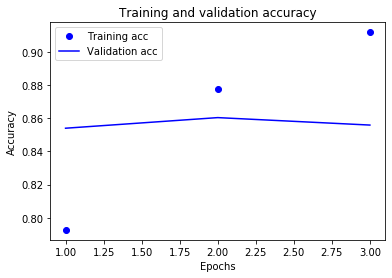

In [20]:
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 그래프 시각화 GlobalAveragePooling1D layer

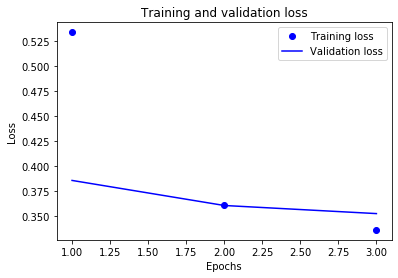

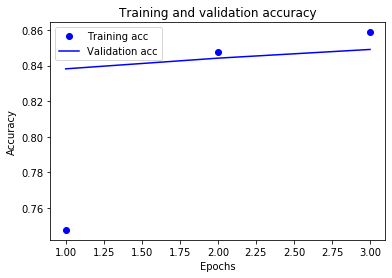

In [21]:
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding 레이어 분석
**순서**
1. LSTM
2. 1-D CNN
3. GlobalAveragePooling1D layer

In [22]:
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_simple = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

In [23]:
word_vectors_lstm.similar_by_word("배우")

[('유지태', 0.6178333759307861),
 ('시나리오', 0.6076107025146484),
 ('발휘', 0.5772173404693604),
 ('영상', 0.5709173679351807),
 ('맞', 0.5621339082717896),
 ('송혜교', 0.5582455396652222),
 ('랑', 0.5529106855392456),
 ('보이', 0.5524845123291016),
 ('팬', 0.550761878490448),
 ('싸이코', 0.5461724996566772)]

In [24]:
word_vectors_cnn.similar_by_word("배우")

[('죤', 0.38370412588119507),
 ('으려나', 0.3591236472129822),
 ('안녕', 0.3566408157348633),
 ('역', 0.35330629348754883),
 ('퇴마', 0.34968677163124084),
 ('렌', 0.34868818521499634),
 ('없', 0.34839075803756714),
 ('아님', 0.3428184390068054),
 ('>.', 0.3426065742969513),
 ('츄', 0.3389517664909363)]

In [25]:
word_vectors_simple.similar_by_word("배우")

[('아서', 0.8016413450241089),
 ('너무', 0.801230788230896),
 ('더', 0.7889404892921448),
 ('.', 0.7744522094726562),
 ('것', 0.7599953413009644),
 ('하', 0.7595878839492798),
 ('제', 0.7595381736755371),
 ('이렇게', 0.7588602304458618),
 ('로', 0.7498327493667603),
 ('같', 0.7475125789642334)]

### 한국어 Word2Vec 적용

In [26]:
import pprint

path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_vec = Word2Vec.load(path)

print(ko_vec.wv["배우"]) # ko_vec["배우"]방식은 deprecated라고 한다.
pprint.pprint(ko_vec.wv.most_similar("배우")) #마찬가지로 ko_vec.most_similar() 방식도 deprecated. 지양하자.

ko_vec = ko_vec.wv # ko_vec.wv대신 ko_vec을 사용하면 아래에서도 deprecated 경고 발생

[ 0.16752283 -1.4403394   2.8093226  -2.2942572   0.13433917 -1.0179986
 -1.6604831   1.4500121   0.26260966 -0.9908764  -0.86152965  0.2907808
 -0.71542895  0.11167914 -0.03550755  1.0984114  -1.266807   -1.73354
  1.6347289  -0.6296538  -0.4523188  -0.5940362  -0.07651725 -1.8494816
 -1.3535714  -2.3276203   1.3144854   1.9779409  -0.4396118   1.5602161
  1.4577893   1.1083381   0.65025765  0.51086545  0.1116109   0.46636197
 -0.50944877 -0.5409319  -1.0953526  -2.4960513  -0.28755617 -0.7519181
  0.6840282  -0.69424474 -0.24744606  0.03568178  3.426236   -2.2075064
 -0.38595662 -0.11880949  1.7459064  -1.8460087   1.8704582  -0.8907359
  0.258816    0.46029854  2.7752008   0.83754796 -1.1874206   0.22281261
  2.1227393   0.64509875 -2.9229567   1.8654289  -0.32230487 -1.6857306
  0.39045802  0.935903    0.02172696  0.0644962   0.9145913  -0.95547587
 -1.2014496  -0.16720626  0.86859787  0.07173832  0.60098696  0.5265061
  1.744407   -0.01287265 -1.8676045  -0.30340263  1.6570233  -1

In [27]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 200

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

### 모델에 Word2Vec 적용

In [28]:
vocab_size = 10000
word_vector_dim = 200 #https://github.com/Kyubyong/wordvectors 참고. 한국어 word2vec는 벡터 사이즈가 200이다.

lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 2,185,089
Trainable params: 2,185,089
Non-trainable params: 0
_________________________________________________________________


In [29]:
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
dropout (Dropout)            (None, 41, 200)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 512)           717312    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 512)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 512)            1835520   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)              

In [60]:
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))

simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(128, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
global_average_pooling1d_10  (None, 200)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 129       
Total params: 2,025,857
Trainable params: 2,025,857
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련 LSTM

In [33]:
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 12s 49ms/step - loss: 0.4464 - accuracy: 0.7849 - val_loss: 0.3962 - val_accuracy: 0.8221
Epoch 2/4
247/247 [==============================] - 12s 49ms/step - loss: 0.3227 - accuracy: 0.8605 - val_loss: 0.3268 - val_accuracy: 0.8580
Epoch 3/4
247/247 [==============================] - 12s 47ms/step - loss: 0.2788 - accuracy: 0.8833 - val_loss: 0.3204 - val_accuracy: 0.8616
Epoch 4/4
247/247 [==============================] - 11s 45ms/step - loss: 0.2477 - accuracy: 0.8981 - val_loss: 0.3194 - val_accuracy: 0.8633


### 모델 훈련 1-D CNN

In [34]:
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10

history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 26s 104ms/step - loss: 0.6642 - accuracy: 0.6691 - val_loss: 0.4573 - val_accuracy: 0.7849
Epoch 2/10
247/247 [==============================] - 15s 60ms/step - loss: 0.4503 - accuracy: 0.7866 - val_loss: 0.3811 - val_accuracy: 0.8305
Epoch 3/10
247/247 [==============================] - 15s 59ms/step - loss: 0.3898 - accuracy: 0.8229 - val_loss: 0.3512 - val_accuracy: 0.8475
Epoch 4/10
247/247 [==============================] - 14s 57ms/step - loss: 0.3547 - accuracy: 0.8416 - val_loss: 0.3398 - val_accuracy: 0.8524
Epoch 5/10
247/247 [==============================] - 13s 54ms/step - loss: 0.3296 - accuracy: 0.8553 - val_loss: 0.3321 - val_accuracy: 0.8534
Epoch 6/10
247/247 [==============================] - 14s 58ms/step - loss: 0.3086 - accuracy: 0.8650 - val_loss: 0.3261 - val_accuracy: 0.8572
Epoch 7/10
247/247 [==============================] - 15s 59ms/step - loss: 0.2915 - accuracy: 0.8735 - val_loss: 0.3300 - val_accuracy

### 모델 훈련 GlobalAveragePooling1D layer

In [61]:
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 8

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
247/247 [==============================] - 8s 32ms/step - loss: 0.5540 - accuracy: 0.7138 - val_loss: 0.4422 - val_accuracy: 0.8013
Epoch 2/8
247/247 [==============================] - 8s 32ms/step - loss: 0.4078 - accuracy: 0.8183 - val_loss: 0.3761 - val_accuracy: 0.8381
Epoch 3/8
247/247 [==============================] - 8s 33ms/step - loss: 0.3615 - accuracy: 0.8428 - val_loss: 0.3550 - val_accuracy: 0.8451
Epoch 4/8
247/247 [==============================] - 9s 35ms/step - loss: 0.3397 - accuracy: 0.8532 - val_loss: 0.3499 - val_accuracy: 0.8462
Epoch 5/8
247/247 [==============================] - 8s 32ms/step - loss: 0.3283 - accuracy: 0.8589 - val_loss: 0.3492 - val_accuracy: 0.8454
Epoch 6/8
247/247 [==============================] - 8s 32ms/step - loss: 0.3199 - accuracy: 0.8633 - val_loss: 0.3443 - val_accuracy: 0.8486
Epoch 7/8
247/247 [==============================] - 8s 33ms/step - loss: 0.3128 - accuracy: 0.8669 - val_loss: 0.3447 - val_accuracy: 0.8485
Epoch 

### 모델 평가

In [40]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

1537/1537 - 6s - loss: 0.3265 - accuracy: 0.8610
[0.3265365660190582, 0.8610167503356934]


In [41]:
# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

1537/1537 - 6s - loss: 0.3519 - accuracy: 0.8535
[0.35187026858329773, 0.8535102009773254]


In [58]:
# GlobalAveragePooling1D
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

1537/1537 - 3s - loss: 0.3552 - accuracy: 0.8460
[0.3552466034889221, 0.8459832668304443]


## 회고

### 정리

텍스트 분석을 통해 리뷰가 긍정인지 부정인지를 분류하는 모델을 만드는 것이 목표였다.

처음엔 학습된 워드 벡터를 적용하지 않고, 모델을 구성했다.

정확도는 LSTM과 MaxPooling1D 레이어를 하나만 사용해 구성한 모델이 84 퍼센트 대였고, 1-D CNN이 유일하게 85 퍼센트를 넘었다.

정확도는 목표로 한 85 퍼센트에 근접하거나 넘었지만, 학습한 벡터들을 확인하기 위해 각각의 모델이 내놓은 벡터 값 중 "배우"라는 단어의 벡터 값과 가장 유사한 벡터 값을 출력해보니, 세 모델 모두 전체적으로 "배우"와 유사하다고 할 수 있는 단어를 반환하지 못했다.

그래서 학습된 워드 임베딩을 적용한 모델을 테스트해봤다. (https://github.com/Kyubyong/wordvectors 에서 다운로드 받을 수 있다.)

한국어 Word2Vec 파일을 읽어오고, "배우"와 유사한 값을 갖는 벡터들을 출력해보니, "영화배우", "연출가", "연극배우" 등 전반적으로 자체 워드 임베딩의 벡터보다 유사한 단어를 출력하는 걸 확인할 수 있었다.

이 벡터값들을 각 모델의 임베딩 레이어에 적용하고 학습과 평가를 해보니 생각과는 다른 결과가 나왔다.

같은 조건에서 오히려 테스트 정확도가 낮게 나왔고, 모델들의 hyperparameter값을 조정한 후에야 LSTM 모델만 85 퍼센트를 넘었다.

올바른 추론인지는 모르곘지만, 첫 번째 epoch부터 training accuracy와 validation accuracy가 높게 나오고, 2~3번쨰 epoch부터는 training accuracy만 오르고 validation accuracy는 오히려 떨어지는 경향을 보이길래 처음부터 빠르게 학습 데이터에 과적합되는 것인지 궁금해서 1-D CNN 모델에 Dropout 레이어를 추가했더니 1-D CNN 모델도 85 퍼센트를 넘었다. 

하지만 GlobalMaxPooling1D레이어와 GlobalAveragePooling1D레이어 하나만 적용한 모델은 85 퍼센트의 벽을 넘지 못했다.



